In [ ]:
#dqn

In [ ]:
#https://github.com/openai/gym/blob/master/gym/envs/classic_control/acrobot.py

In [ ]:
#https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/acrobot.ipynb

In [ ]:
"""classic Acrobot task"""
from typing import Optional

import numpy as np
from numpy import cos, pi, sin

from gym import core, logger, spaces
from gym.error import DependencyNotInstalled

__copyright__ = "Copyright 2013, RLPy http://acl.mit.edu/RLPy"
__credits__ = [
    "Alborz Geramifard",
    "Robert H. Klein",
    "Christoph Dann",
    "William Dabney",
    "Jonathan P. How",
]
__license__ = "BSD 3-Clause"
__author__ = "Christoph Dann <cdann@cdann.de>"

# SOURCE:
# https://github.com/rlpy/rlpy/blob/master/rlpy/Domains/Acrobot.py
from gym.envs.classic_control import utils


class Custom_AcrobotEnv(core.Env):
    """
    ### Description
    The Acrobot environment is based on Sutton's work in
    ["Generalization in Reinforcement Learning: Successful Examples Using Sparse Coarse Coding"](https://papers.nips.cc/paper/1995/hash/8f1d43620bc6bb580df6e80b0dc05c48-Abstract.html)
    and [Sutton and Barto's book](http://www.incompleteideas.net/book/the-book-2nd.html).
    The system consists of two links connected linearly to form a chain, with one end of
    the chain fixed. The joint between the two links is actuated. The goal is to apply
    torques on the actuated joint to swing the free end of the linear chain above a
    given height while starting from the initial state of hanging downwards.
    As seen in the **Gif**: two blue links connected by two green joints. The joint in
    between the two links is actuated. The goal is to swing the free end of the outer-link
    to reach the target height (black horizontal line above system) by applying torque on
    the actuator.
    ### Action Space
    The action is discrete, deterministic, and represents the torque applied on the actuated
    joint between the two links.
    | Num | Action                                | Unit         |
    |-----|---------------------------------------|--------------|
    | 0   | apply -1 torque to the actuated joint | torque (N m) |
    | 1   | apply 0 torque to the actuated joint  | torque (N m) |
    | 2   | apply 1 torque to the actuated joint  | torque (N m) |
    ### Observation Space
    The observation is a `ndarray` with shape `(6,)` that provides information about the
    two rotational joint angles as well as their angular velocities:
    | Num | Observation                  | Min                 | Max               |
    |-----|------------------------------|---------------------|-------------------|
    | 0   | Cosine of `theta1`           | -1                  | 1                 |
    | 1   | Sine of `theta1`             | -1                  | 1                 |
    | 2   | Cosine of `theta2`           | -1                  | 1                 |
    | 3   | Sine of `theta2`             | -1                  | 1                 |
    | 4   | Angular velocity of `theta1` | ~ -12.567 (-4 * pi) | ~ 12.567 (4 * pi) |
    | 5   | Angular velocity of `theta2` | ~ -28.274 (-9 * pi) | ~ 28.274 (9 * pi) |
    where
    - `theta1` is the angle of the first joint, where an angle of 0 indicates the first link is pointing directly
    downwards.
    - `theta2` is ***relative to the angle of the first link.***
        An angle of 0 corresponds to having the same angle between the two links.
    The angular velocities of `theta1` and `theta2` are bounded at ±4π, and ±9π rad/s respectively.
    A state of `[1, 0, 1, 0, ..., ...]` indicates that both links are pointing downwards.
    ### Rewards
    The goal is to have the free end reach a designated target height in as few steps as possible,
    and as such all steps that do not reach the goal incur a reward of -1.
    Achieving the target height results in termination with a reward of 0. The reward threshold is -100.
    ### Starting State
    Each parameter in the underlying state (`theta1`, `theta2`, and the two angular velocities) is initialized
    uniformly between -0.1 and 0.1. This means both links are pointing downwards with some initial stochasticity.
    ### Episode End
    The episode ends if one of the following occurs:
    1. Termination: The free end reaches the target height, which is constructed as:
    `-cos(theta1) - cos(theta2 + theta1) > 1.0`
    2. Truncation: Episode length is greater than 500 (200 for v0)
    ### Arguments
    No additional arguments are currently supported.
    ```
    env = gym.make('Acrobot-v1')
    ```
    By default, the dynamics of the acrobot follow those described in Sutton and Barto's book
    [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/11/node4.html).
    However, a `book_or_nips` parameter can be modified to change the pendulum dynamics to those described
    in the original [NeurIPS paper](https://papers.nips.cc/paper/1995/hash/8f1d43620bc6bb580df6e80b0dc05c48-Abstract.html).
    ```
    # To change the dynamics as described above
    env.env.book_or_nips = 'nips'
    ```
    See the following note and
    the [implementation](https://github.com/openai/gym/blob/master/gym/envs/classic_control/acrobot.py) for details:
    > The dynamics equations were missing some terms in the NIPS paper which
            are present in the book. R. Sutton confirmed in personal correspondence
            that the experimental results shown in the paper and the book were
            generated with the equations shown in the book.
            However, there is the option to run the domain with the paper equations
            by setting `book_or_nips = 'nips'`
    ### Version History
    - v1: Maximum number of steps increased from 200 to 500. The observation space for v0 provided direct readings of
    `theta1` and `theta2` in radians, having a range of `[-pi, pi]`. The v1 observation space as described here provides the
    sine and cosine of each angle instead.
    - v0: Initial versions release (1.0.0) (removed from gym for v1)
    ### References
    - Sutton, R. S. (1996). Generalization in Reinforcement Learning: Successful Examples Using Sparse Coarse Coding.
        In D. Touretzky, M. C. Mozer, & M. Hasselmo (Eds.), Advances in Neural Information Processing Systems (Vol. 8).
        MIT Press. https://proceedings.neurips.cc/paper/1995/file/8f1d43620bc6bb580df6e80b0dc05c48-Paper.pdf
    - Sutton, R. S., Barto, A. G. (2018 ). Reinforcement Learning: An Introduction. The MIT Press.
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 15,
    }

    dt = 0.2

    LINK_LENGTH_1 = 1.0  # [m]
    LINK_LENGTH_2 = 1.0  # [m]
    LINK_MASS_1 = 1.0  #: [kg] mass of link 1
    LINK_MASS_2 = 1.0  #: [kg] mass of link 2
    LINK_COM_POS_1 = 0.5  #: [m] position of the center of mass of link 1
    LINK_COM_POS_2 = 0.5  #: [m] position of the center of mass of link 2
    LINK_MOI = 1.0  #: moments of inertia for both links

    MAX_VEL_1 = 4 * pi
    MAX_VEL_2 = 9 * pi

    AVAIL_TORQUE = [-1.0, 0.0, +1]##################################################################################
    #AVAIL_TORQUE = [-10.0, 0.0, +10]

    torque_noise_max = 0.0

    SCREEN_DIM = 500

    #: use dynamics equations from the nips paper or the book
    book_or_nips = "book"
    action_arrow = None
    domain_fig = None
    actions_num = 3

    def __init__(self, render_mode: Optional[str] = None):
        self.render_mode = render_mode
        self.screen = None
        self.clock = None
        self.isopen = True
        high = np.array(
            [1.0, 1.0, 1.0, 1.0, self.MAX_VEL_1, self.MAX_VEL_2], dtype=np.float32
        )
        low = -high
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)
        self.action_space = spaces.Discrete(3)
        self.state = None

                ### Customization changes ######
        '''add ElectricalDCMotorEnv to the CartPole class
        and assign values to
        Resistor_R, inductor_L, torque_const_Kt and bemf_const_Ke'''
        self.tau1 = self.dt/10  # seconds between state updates
        #self.Resistor_R=1.0
        #self.inductor_L=0.1
        #self.torque_const_Kt=1.0
        #self.bemf_const_Ke=1.0
        self.DCMotorModel = ElectricalDCMotorEnv()
        self.DCMotorModel.tau1 = self.tau1
        self.DCMotorModel.Resistor_R = 1.0
        self.DCMotorModel.inductor_L = 0.1
        self.DCMotorModel.torque_const_Kt = 1.0
        self.DCMotorModel.bemf_const_Ke = 1.0
        ####

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(
            options, -0.1, 0.1  # default low
        )  # default high
        self.state = self.np_random.uniform(low=low, high=high, size=(4,)).astype(
            np.float32
        )

        self.DCMotorModel.current = 0.0
        self.DCMotorModel.current_error = 0.0
        self.DCMotorModel.current_error_acc = 0.0
        self.DCMotorModel.current_error_prev = 0.0

        if self.render_mode == "human":
            self.render()
        return self._get_ob(), {}#####################################################################################################################

    def step(self, a):
        s = self.state

        #[cos(s[0]), sin(s[0]), cos(s[1]), sin(s[1]), s[2], s[3]]
        #aa, x_dot, bb, cc, dd, ee = s
        #x_dot = cos(s[0])


        assert s is not None, "Call reset before using AcrobotEnv object."
        ns=np.asarray(s)
        wanted_torque = self.AVAIL_TORQUE[a]

        current_ref = wanted_torque/self.DCMotorModel.torque_const_Kt################################################################################################
        #print("current_ref", current_ref)
        for t in np.arange(start=0.0, stop=self.dt, step=self.tau1):
          actual_torque = self.DCMotorModel.step(current_ref = current_ref, theta_dot = ns[3])
          #actual_torque = wanted_torque
          #print("F", actual_torque)
                  # Add noise to the force action
          '''
          if self.torque_noise_max > 0:
              actual_torque += self.np_random.uniform(                       #######################################################################
                  -self.torque_noise_max, self.torque_noise_max
              )
          '''
          # Now, augment the state with our force action so it can be passed to
          # _dsdt
          #s_augmented = np.append(s, torque)######################################################################################################maybe!!!!!!!!!!!!!
          s_augmented = np.append(ns, actual_torque)######################################################################################################maybe!!!!!!!!!!!!!
          #print('s_augmented',s_augmented)
          ns = rk4(self._dsdt, s_augmented, [0, self.tau1])
          #print('ns',ns)
          ns[0] = wrap(ns[0], -pi, pi)
          ns[1] = wrap(ns[1], -pi, pi)
          ns[2] = bound(ns[2], -self.MAX_VEL_1, self.MAX_VEL_1)
          ns[3] = bound(ns[3], -self.MAX_VEL_2, self.MAX_VEL_2)


        self.state = ns
        #print("self.state :",self.state)
        #print("self._get_ob() :",self._get_ob())
        terminated = self._terminal()
        reward = -1.0 if not terminated else 0.0

        #if self.render_mode == "human":
        #    self.render()
        return self._get_ob(), reward, terminated, False , wanted_torque, actual_torque###############################################################################################################

    def _get_ob(self):
        s = self.state
        assert s is not None, "Call reset before using AcrobotEnv object."
        return np.array(
            [cos(s[0]), sin(s[0]), cos(s[1]), sin(s[1]), s[2], s[3]], dtype=np.float32
        )

    def _terminal(self):
        s = self.state
        assert s is not None, "Call reset before using AcrobotEnv object."
        return bool(-cos(s[0]) - cos(s[1] + s[0]) > 1.0)

    def _dsdt(self, s_augmented):
        m1 = self.LINK_MASS_1
        m2 = self.LINK_MASS_2
        l1 = self.LINK_LENGTH_1
        lc1 = self.LINK_COM_POS_1
        lc2 = self.LINK_COM_POS_2
        I1 = self.LINK_MOI
        I2 = self.LINK_MOI
        g = 9.8
        a = s_augmented[-1]
        s = s_augmented[:-1]
        theta1 = s[0]
        theta2 = s[1]
        dtheta1 = s[2]
        dtheta2 = s[3]
        d1 = (
            m1 * lc1**2
            + m2 * (l1**2 + lc2**2 + 2 * l1 * lc2 * cos(theta2))
            + I1
            + I2
        )
        d2 = m2 * (lc2**2 + l1 * lc2 * cos(theta2)) + I2
        phi2 = m2 * lc2 * g * cos(theta1 + theta2 - pi / 2.0)
        phi1 = (
            -m2 * l1 * lc2 * dtheta2**2 * sin(theta2)
            - 2 * m2 * l1 * lc2 * dtheta2 * dtheta1 * sin(theta2)
            + (m1 * lc1 + m2 * l1) * g * cos(theta1 - pi / 2)
            + phi2
        )
        if self.book_or_nips == "nips":
            # the following line is consistent with the description in the
            # paper
            ddtheta2 = (a + d2 / d1 * phi1 - phi2) / (m2 * lc2**2 + I2 - d2**2 / d1)
        else:
            # the following line is consistent with the java implementation and the
            # book
            ddtheta2 = (
                a + d2 / d1 * phi1 - m2 * l1 * lc2 * dtheta1**2 * sin(theta2) - phi2
            ) / (m2 * lc2**2 + I2 - d2**2 / d1)
        ddtheta1 = -(d2 * ddtheta2 + phi1) / d1
        return dtheta1, dtheta2, ddtheta1, ddtheta2, 0.0

    def render(self):
        if self.render_mode is None:
            logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.SCREEN_DIM, self.SCREEN_DIM)
                )
            else:  # mode in "rgb_array"
                self.screen = pygame.Surface((self.SCREEN_DIM, self.SCREEN_DIM))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        surf = pygame.Surface((self.SCREEN_DIM, self.SCREEN_DIM))
        surf.fill((255, 255, 255))
        s = self.state

        bound = self.LINK_LENGTH_1 + self.LINK_LENGTH_2 + 0.2  # 2.2 for default
        scale = self.SCREEN_DIM / (bound * 2)
        offset = self.SCREEN_DIM / 2

        if s is None:
            return None

        p1 = [
            -self.LINK_LENGTH_1 * cos(s[0]) * scale,
            self.LINK_LENGTH_1 * sin(s[0]) * scale,
        ]

        p2 = [
            p1[0] - self.LINK_LENGTH_2 * cos(s[0] + s[1]) * scale,
            p1[1] + self.LINK_LENGTH_2 * sin(s[0] + s[1]) * scale,
        ]

        xys = np.array([[0, 0], p1, p2])[:, ::-1]
        thetas = [s[0] - pi / 2, s[0] + s[1] - pi / 2]
        link_lengths = [self.LINK_LENGTH_1 * scale, self.LINK_LENGTH_2 * scale]

        pygame.draw.line(
            surf,
            start_pos=(-2.2 * scale + offset, 1 * scale + offset),
            end_pos=(2.2 * scale + offset, 1 * scale + offset),
            color=(0, 0, 0),
        )

        for ((x, y), th, llen) in zip(xys, thetas, link_lengths):
            x = x + offset
            y = y + offset
            l, r, t, b = 0, llen, 0.1 * scale, -0.1 * scale
            coords = [(l, b), (l, t), (r, t), (r, b)]
            transformed_coords = []
            for coord in coords:
                coord = pygame.math.Vector2(coord).rotate_rad(th)
                coord = (coord[0] + x, coord[1] + y)
                transformed_coords.append(coord)
            gfxdraw.aapolygon(surf, transformed_coords, (0, 204, 204))
            gfxdraw.filled_polygon(surf, transformed_coords, (0, 204, 204))

            gfxdraw.aacircle(surf, int(x), int(y), int(0.1 * scale), (204, 204, 0))
            gfxdraw.filled_circle(surf, int(x), int(y), int(0.1 * scale), (204, 204, 0))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


def wrap(x, m, M):
    """Wraps ``x`` so m <= x <= M; but unlike ``bound()`` which
    truncates, ``wrap()`` wraps x around the coordinate system defined by m,M.\n
    For example, m = -180, M = 180 (degrees), x = 360 --> returns 0.
    Args:
        x: a scalar
        m: minimum possible value in range
        M: maximum possible value in range
    Returns:
        x: a scalar, wrapped
    """
    diff = M - m
    while x > M:
        x = x - diff
    while x < m:
        x = x + diff
    return x


def bound(x, m, M=None):
    """Either have m as scalar, so bound(x,m,M) which returns m <= x <= M *OR*
    have m as length 2 vector, bound(x,m, <IGNORED>) returns m[0] <= x <= m[1].
    Args:
        x: scalar
        m: The lower bound
        M: The upper bound
    Returns:
        x: scalar, bound between min (m) and Max (M)
    """
    if M is None:
        M = m[1]
        m = m[0]
    # bound x between min (m) and Max (M)
    return min(max(x, m), M)


def rk4(derivs, y0, t):
    """
    Integrate 1-D or N-D system of ODEs using 4-th order Runge-Kutta.
    Example for 2D system:
        >>> def derivs(x):
        ...     d1 =  x[0] + 2*x[1]
        ...     d2 =  -3*x[0] + 4*x[1]
        ...     return d1, d2
        >>> dt = 0.0005
        >>> t = np.arange(0.0, 2.0, dt)
        >>> y0 = (1,2)
        >>> yout = rk4(derivs, y0, t)
    Args:
        derivs: the derivative of the system and has the signature ``dy = derivs(yi)``
        y0: initial state vector
        t: sample times
    Returns:
        yout: Runge-Kutta approximation of the ODE
    """

    try:
        Ny = len(y0)
    except TypeError:
        yout = np.zeros((len(t),), np.float_)
    else:
        yout = np.zeros((len(t), Ny), np.float_)

    yout[0] = y0

    for i in np.arange(len(t) - 1):

        this = t[i]
        dt = t[i + 1] - this
        dt2 = dt / 2.0
        y0 = yout[i]

        k1 = np.asarray(derivs(y0))
        k2 = np.asarray(derivs(y0 + dt2 * k1))
        k3 = np.asarray(derivs(y0 + dt2 * k2))
        k4 = np.asarray(derivs(y0 + dt * k3))
        yout[i + 1] = y0 + dt / 6.0 * (k1 + 2 * k2 + 2 * k3 + k4)
    # We only care about the final timestep and we cleave off action value which will be zero
    return yout[-1][:4]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class ElectricalDCMotorEnv():

      def __init__(self):
        self.Resistor_R = 1.0
        self.inductor_L = 0.1
        self.torque_const_Kt = 1.0
        self.bemf_const_Ke = 1.0
        #self.tau1 = 1##############################################################################################################################
        self.tau1 = 0.05
        #
        self.Kp = 1.0
        self.Ki = 10.0
        self.Kd = 10**(-6)
        self.aL=10**(-3)#Low pass parameter
        self.aH = 10**2 #High pass parameter

        #self.Kp = 5.0
        #self.Ki = 5.0
        #self.Kd = 10.0**(-2)
        #self.aL=10.0**(-3) #Low pass parameter
        #self.aH = 10.0**2 #High pass parameter
        #
        self.current = 0.0
        self.current_error = 0.0
        self.current_error_acc = 0.0
        self.current_error_prev = 0.0
        self.voltage_input = 0.0
        self.theta_dot = 0.0
        self.PID_Discretization = "Simple" #"Backward", " "Bilinear" , "Forward" "Simple"
        #self.PID_Discretization = "Backward" #"Backward""Simple", " "Bilinear" , "Forward" "Simple"
        #self.PID_Discretization = "Bilinear" #"Backward""Simple", " "Bilinear" , "Forward" "Simple"

      def step(self, current_ref, theta_dot):
        aL = self.aL
        aH = self.aH
        self.current_error = current_ref-self.current
        delta_error = self.current_error-self.current_error_prev
        #print("current_ref",current_ref)
        #print("self.current",self.current)
        #print("self.current_error",self.current_error)
        #print("self.current_error_prev",self.current_error_prev)
        #print("delta_error",delta_error)

        if self.PID_Discretization == "Simple":
          self.current_error_acc += self.current_error*self.tau1
          HP_delta_error = delta_error

        elif self.PID_Discretization == "Backward":
          self.current_error_acc = (self.current_error_acc+(self.current_error)*self.tau1)/(1+aL*self.tau1) #Low Pass
          HP_delta_error = (self.current_error + aH*delta_error)/(1+aL*self.tau1)#High Pass

        elif self.PID_Discretization == "Bilinear":
          error_avg = (self.current_error+self.current_error_prev)/2
          self.current_error_acc =  ((1-aL*self.tau1/2)*self.current_error_acc + error_avg*self.tau1)/(1+aL*self.tau1/2)#Low Pass
          HP_delta_error =  ((1-aL*self.tau1/2)*self.current_error + aH*delta_error)/(1+aL*self.tau1/2)#High Pass

        else:
          self.current_error_acc = (1-aL*self.tau1)*self.current_error_acc+(self.current_error_prev)*self.tau1 #Low Pass
          HP_delta_error = (1-aH*self.tau1)*self.current_error + aH*delta_error #High Pass

        P = self.Kp*self.current_error
        #I = self.Ki*self.current_error_acc*self.tau1
        I = self.Ki*self.current_error_acc
        #D = self.Kd*HP_delta_error/self.tau1
        D = self.Kd*HP_delta_error/self.tau1
        #voltage_input = P+I+D


        voltage_BEMF = theta_dot*self.bemf_const_Ke
        #print("voltage_BEMF",voltage_BEMF)
        voltage_input = P+I+D+voltage_BEMF
        voltage_input = np.clip(voltage_input, -10, 10)
        #print("voltage_input",voltage_input)

        self.current_error_prev = 0+self.current_error
        #print("self.current_error_prev",self.current_error_prev)
        self.current += self.tau1*(voltage_input-voltage_BEMF-self.current*self.Resistor_R)/self.inductor_L
        self.current = np.clip(self.current, -10, 10)
        #print("self.current",self.current)
        self.voltage_input = voltage_input
        #print("self.voltage_input",self.voltage_input)
        self.theta_dot = theta_dot
        #print("self.xdot",self.xdot)
        torque = self.torque_const_Kt*self.current

        return torque # return applied torque

In [ ]:
env =  Custom_AcrobotEnv()
env.DCMotorModel.PID_Discretization ="Simple" # "Forward" or "Backward" or" "Bilinear" or "Simple"

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from collections import deque,namedtuple

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 337 kB in 2s (139 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
19 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://cloud.r-project.org/bin/linu

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
#from gym.wrappers import Monitor

In [ ]:

display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
'''
import gym
#env = gym.make('Acrobot-v1')
env =  Custom_AcrobotEnv()
env.seed(0)

print(env.action_space)
print(env.observation_space)
'''

"\nimport gym\n#env = gym.make('Acrobot-v1')\nenv =  Custom_AcrobotEnv()\nenv.seed(0)\n\nprint(env.action_space)\nprint(env.observation_space)\n"

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        # Define a queue with maxlen "capacity"
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        # Randomly select "batch_size" samples and return the selection
        return random.sample(self.memory,batch_size)

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                  nn.Linear(state_space_dim,64),
                  nn.ReLU(),
                  nn.Linear(64,64*2),
                  nn.ReLU(),
                  nn.Linear(64*2,action_space_dim)
                )

    def forward(self, x):
        x = x.to(device)
        return self.linear(x)

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):

    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')

    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions (this list includes all the actions but the optimal one)
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly from non_optimal_actions
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action

    return action, net_out.cpu().numpy()

In [ ]:
def choose_action_softmax(net, state, temperature):

    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')

    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)

    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out/temperature, dim=0).cpu().numpy()

    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    action = np.random.choice(all_possible_actions,p=softmax_out)

    return action, net_out.cpu().numpy()

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

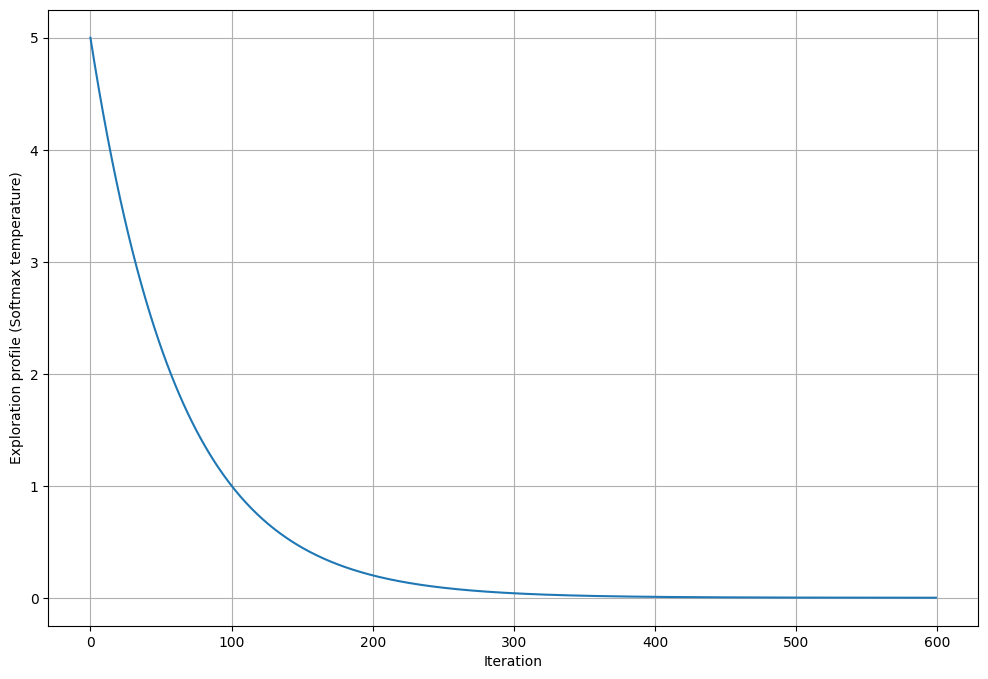

In [ ]:
### Define exploration profile
initial_value = 5
#num_iterations = 800
#num_iterations = 10
num_iterations = 600 #########change try 600 to 200
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]
score_low_bound = -2000 ###change add score low bound


### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [ ]:
### Create environment
#env = gym.make('Acrobot-v1') # Initialize the Gym environment
env =  Custom_AcrobotEnv()
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 6
ACTION SPACE SIZE: 3


/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)

### PARAMETERS
gamma = 0.99   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
#lr = 1e-2   # Optimizer learning rate
#lr = 1e-4
lr = 1e-3
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 256   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down)
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim).to(device)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()


In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):

    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32, device=device)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64, device=device)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32, device=device)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32, device=device) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1).cuda())

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size, device=device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1)# Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()



In [ ]:
# Initialize the Gym environment
#env = gym.make('Acrobot-v1')
env =  Custom_AcrobotEnv()
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

plotting_rewards=[]

save_observation = []
save_u1 = []
save_pid_u1 = []


for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    state = state[0]###################################################################################################################################################
    #print("state_1 :",  state)
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      #print('1')

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

      #print("action :", action)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      #print('2')
      #self._get_ob(), reward, terminated, False , torque, F
      next_state, reward, done, info, force1, F1 = env.step(action)#############################################
      #print('3')
      if episode_num == len(exploration_profile) - 1 :################################################################################
        save_observation.append(next_state)
        save_u1.append(force1)
        save_pid_u1.append(F1)
        #print('4')

      # Update the final score (+1 for each step)
      score += reward

      if score<score_low_bound: ##### change  to stop high negative score
        done =True

      # Apply penalty for bad state

      if done: # if the pole has fallen down
          reward += bad_state_penalty
          next_state = None
          #print('5')

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    plotting_rewards.append(score)
    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score}; wanted torqe={force1}, actual torque={F1}") # Print the final score

env.close()

  0%|          | 0/600 [00:00<?, ?it/s]

<ipython-input-21-1720ada3995b>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  states      = torch.tensor([s[0] for s in batch], dtype=torch.float32, device=device)


Updating target network...
EPISODE: 1 - FINAL SCORE: -1682.0; wanted torqe=1, actual torque=0.9921690148947592
EPISODE: 2 - FINAL SCORE: -2001.0; wanted torqe=-1.0, actual torque=-0.9090028545802202
EPISODE: 3 - FINAL SCORE: -1361.0; wanted torqe=1, actual torque=0.7740701726451511
EPISODE: 4 - FINAL SCORE: -1769.0; wanted torqe=0.0, actual torque=0.06780307392691112
EPISODE: 5 - FINAL SCORE: -1184.0; wanted torqe=0.0, actual torque=0.09442072757675918
EPISODE: 6 - FINAL SCORE: -1319.0; wanted torqe=1, actual torque=0.9809456216821755
EPISODE: 7 - FINAL SCORE: -2001.0; wanted torqe=0.0, actual torque=-0.07537853052624369
EPISODE: 8 - FINAL SCORE: -1782.0; wanted torqe=0.0, actual torque=0.08669776218007332
EPISODE: 9 - FINAL SCORE: -1193.0; wanted torqe=1, actual torque=0.9564671454865084
EPISODE: 10 - FINAL SCORE: -1611.0; wanted torqe=0.0, actual torque=0.023699168798376673
Updating target network...
EPISODE: 11 - FINAL SCORE: -1195.0; wanted torqe=0.0, actual torque=0.08374217746431

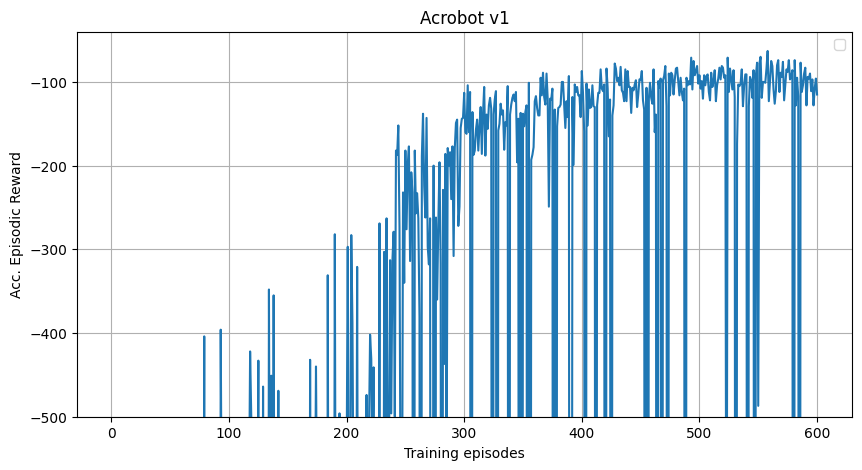

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
#plt.plot(range(1,801),plotting_rewards)##################################################################################change
#plt.plot(range(1,11),plotting_rewards)
plt.plot(range(1,num_iterations+1),plotting_rewards)
plt.xlabel('Training episodes')
plt.ylabel('Acc. Episodic Reward')
plt.ylim([-500,-40])
#plt.grid()
plt.legend()
plt.title('Acrobot v1')
plt.grid()
plt.show()

In [ ]:
print(type(plotting_rewards))

<class 'list'>


In [ ]:
# Compute the moving average of the last 50 numbers
moving_average = []
for i, n in enumerate(plotting_rewards):
    if i < 50:
        # If there are not enough previous elements,
        # append the average of all available elements
        avg = sum(plotting_rewards[:i+1]) / (i+1)
    else:
        # Otherwise, compute the average of the previous 5 elements
        avg = sum(plotting_rewards[i-50:i+1]) / 50
    moving_average.append(avg)



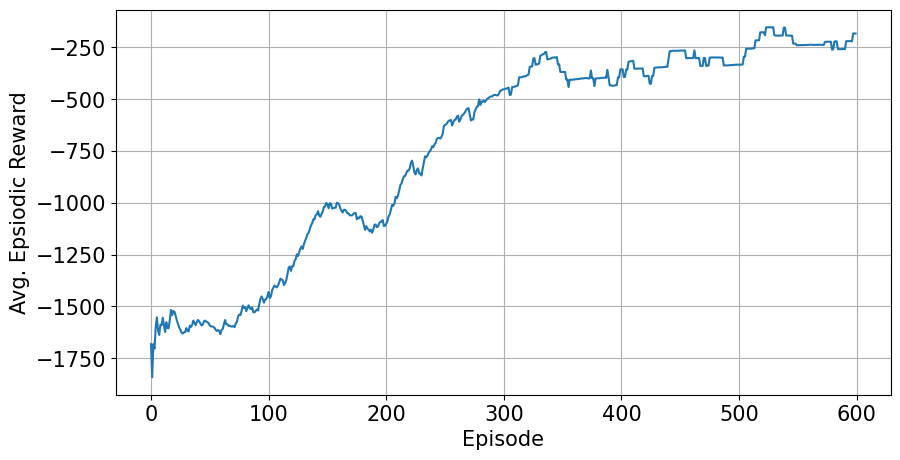

In [ ]:
# Plot the moving average

font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(moving_average)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.grid()
plt.show()

In [ ]:
print(save_pid_u1)

[-0.8864859557180242, -0.9745966494620235, -0.9936481392456252, -0.11190780416860804, -0.024996733407802195, -0.006248915853156698, 0.8849057788300504, 0.9741966309328681, 0.9935468649564841, 0.9983681196213061, 0.9995868913524448, -0.7730764998382604, -0.949219778245614, -0.10081702672010492, -0.9086785233124602, -0.9801357056686234, -0.10856264263174797, 0.8623343270701208, 0.08207569544714256, 0.017525470804690378, 0.8908452693263786, 0.9756984695870499, 0.9939270500947116, 0.9984643725584029, 0.9996112603283989, -0.773070330181739, -0.9492182162322933, -0.9873025869727373, -0.11030316121580892, -0.024590520641484544, -0.0061460733274491695, -0.001554139581674728, 0.8860925292277766, 0.9744970441235857, 0.9936229215197456, -0.7745845360896504, -0.9496015324710931, -0.9873996326315725, -0.9968136866084681, -0.9991933905722611, 0.7731761239851798, 0.9492450007333629, 0.987309368183958, 0.99679083377856, 0.999187604768606, 0.9997943226201534, 0.9999479273296642, -0.7729850950221284, -0

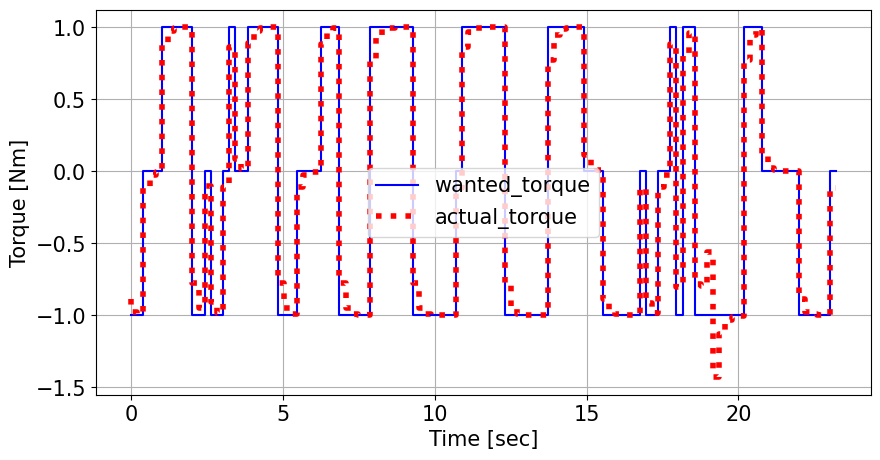

In [ ]:
dt=0.2
time_position_u1= np.linspace(start = 0, stop = len(save_u1)* dt,num=len(save_u1) )
time_position__pid_u1= np.linspace(start = 0, stop = len(save_u1)* dt,num=len(save_u1) )

font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

plt.step(time_position_u1, save_u1 ,label = "wanted_torque",color="blue",linewidth = 1.5)
plt.step(time_position__pid_u1, save_pid_u1 , ':',label = "actual_torque",color="red",linewidth = 4)

#plt.step(time_position_u1, save_u1 ,label = "wanted_torque")
#plt.step(time_position__pid_u1, save_pid_u1 ,label = "actual_torque")
plt.xlabel("Time [sec]")
plt.ylabel("Torque [Nm]")
plt.grid()
plt.legend()
plt.show()

In [ ]:
import math

cos_theta_1 = []
sin_theta_1 = []
cos_theta_2 = []
sin_theta_2 = []
ang_vel_theta_1 = []
ang_vel_theta_2 = []

for observ in save_observation:
  for index,value in enumerate(observ):
    if index == 0:
      #x_print.append(value)
      cos_theta_1.append(value)
      #theta_print.append(math.acos(value))
    if index == 1:
      #y_print.append(value)
      sin_theta_1.append(value)
    if index == 2:
      cos_theta_2.append(value)
    if index == 3:
      sin_theta_2.append(value)
    if index == 4:
      ang_vel_theta_1.append(value)
    if index == 5:
      ang_vel_theta_2.append(value)

In [ ]:
cos_theta_1 = np.array(cos_theta_1)
cos_theta_2 = np.array(cos_theta_2)
sin_theta_1 = np.array(sin_theta_1)
sin_theta_2 = np.array(sin_theta_2)
ang_vel_theta_1 = np.array(ang_vel_theta_1)
ang_vel_theta_2 = np.array(ang_vel_theta_2)

In [ ]:
print(len(cos_theta_1))

116


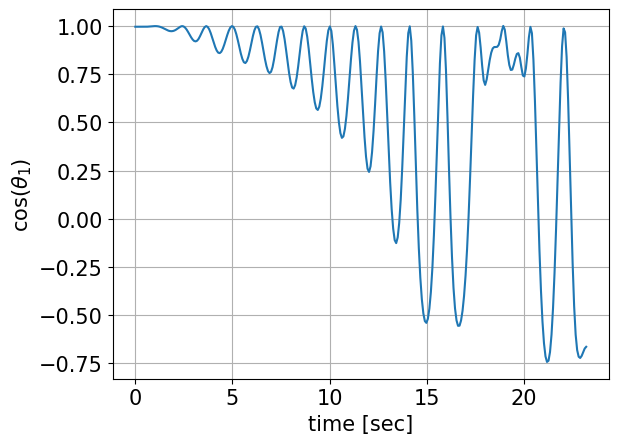

In [ ]:
dt=0.2
from scipy.interpolate import make_interp_spline, BSpline

time_cos_theta_1 = np.linspace(start = 0, stop = len(cos_theta_1)* dt,num=len(cos_theta_1))##############################################
#time_position , position
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_cos_theta_1[-1] , 300)

spl = make_interp_spline(time_cos_theta_1, cos_theta_1, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.grid()
#plt.legend()
plt.xlabel("time [sec]")
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.ylabel(r'$\cos({\theta_1})$')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


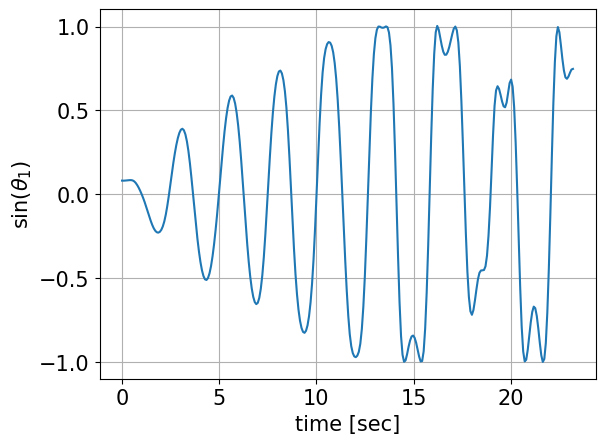

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

time_sin_theta_1 = np.linspace(start = 0, stop = len(sin_theta_1)* dt,num=len(sin_theta_1))##############################################
#time_position , position
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_sin_theta_1[-1] , 300)

spl = make_interp_spline(time_sin_theta_1, sin_theta_1, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.grid()
#plt.legend()
plt.xlabel("time [sec]")
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.ylabel(r'$\sin({\theta_1})$')
plt.show()

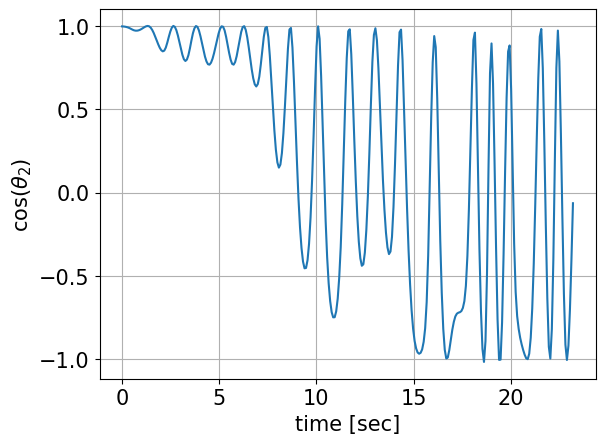

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

time_cos_theta_2 = np.linspace(start = 0, stop = len(cos_theta_2)* dt,num=len(cos_theta_2))##############################################
#time_position , position
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_cos_theta_2[-1] , 300)

spl = make_interp_spline(time_cos_theta_2, cos_theta_2, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.grid()
#plt.legend()
plt.xlabel("time [sec]")
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.ylabel(r'$\cos({\theta_2})$')
plt.show()

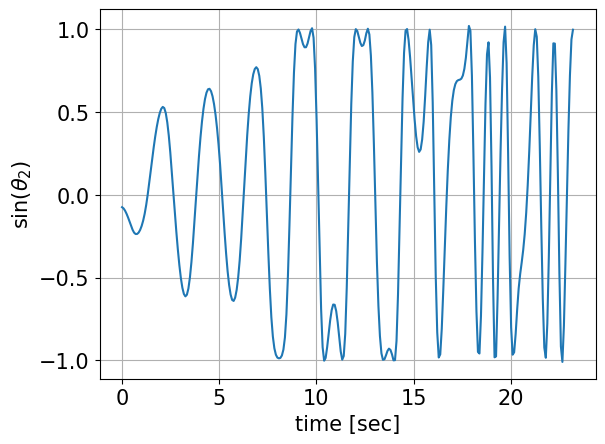

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

time_sin_theta_2 = np.linspace(start = 0, stop = len(sin_theta_2)* dt,num=len(sin_theta_2))##############################################
#time_position , position
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_sin_theta_2[-1] , 300)

spl = make_interp_spline(time_sin_theta_2, sin_theta_2, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.grid()
#plt.legend()
plt.xlabel("time [sec]")
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.ylabel(r'$\sin({\theta_2})$')
plt.show()

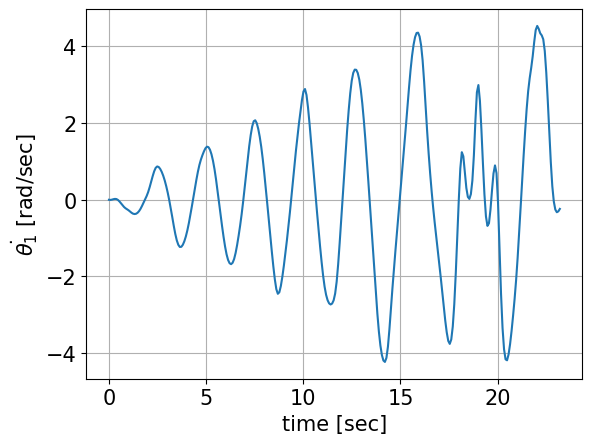

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

time_ang_vel_theta_1 = np.linspace(start = 0, stop = len(ang_vel_theta_1)* dt,num=len(ang_vel_theta_1))##############################################
#time_position , position
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_ang_vel_theta_1[-1] , 300)

spl = make_interp_spline(time_ang_vel_theta_1, ang_vel_theta_1, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.grid()
#plt.legend()
plt.xlabel("time [sec]")
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.ylabel(r'$\dot{\theta_1}$ [rad/sec]')
plt.show()

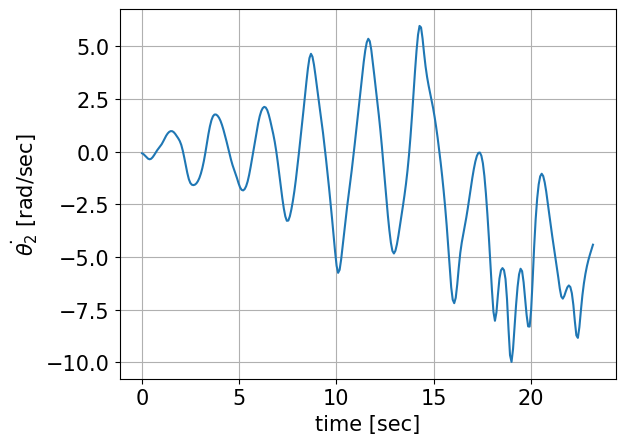

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

time_ang_vel_theta_2 = np.linspace(start = 0, stop = len(ang_vel_theta_2)* dt,num=len(ang_vel_theta_2))##############################################
#time_position , position
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_ang_vel_theta_2[-1] , 300)

spl = make_interp_spline(time_ang_vel_theta_2, ang_vel_theta_2, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.grid()
#plt.legend()
plt.xlabel("time [sec]")
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.ylabel(r'$\dot{\theta_2}$ [rad/sec]')
plt.show()

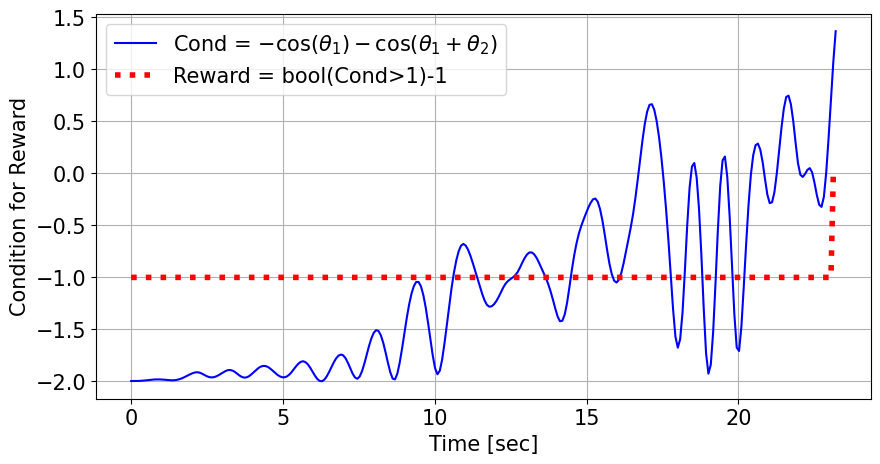

In [ ]:
Condition = -cos_theta_1 -cos_theta_1*cos_theta_2 + sin_theta_1*sin_theta_2
spl = make_interp_spline(time_sin_theta_2, Condition, k=3)  # type: BSpline
power_smooth = spl(xnew)

font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

plt.plot(xnew, power_smooth, label = r'Cond = $-\cos(\theta_1)-\cos({\theta_1+\theta_2})$',color="blue")
plt.plot(xnew, (power_smooth>1)-1,':', label = r'Reward = bool(Cond>1)-1',color="red", linewidth = 4)

plt.grid()
#plt.legend()
plt.xlabel("Time [sec]")
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.ylabel('Condition for Reward')
plt.legend()
plt.show()

In [ ]:
# Initialize the Gym environment
#env = gym.make('Acrobot-v1')
env =  Custom_AcrobotEnv()
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

plotting_rewards2=[]
# Let's try for a total of 10 episodes
for num_episode in range(10):
    # Reset the environment and get the initial state
    state = env.reset()
    state = state[0]##################################################################################################################################
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info , wanted_torque, actual_torque = env.step(action)
      # Visually render the environment
      #env.render()
      # Update the final score (+1 for each step)
      score += reward
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
      if score<score_low_bound: ##### change  to stop high negative score
        done =True
    # Print the final score
    plotting_rewards2.append(score)
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}")
env.close()

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


EPISODE 1 - FINAL SCORE: -121.0
EPISODE 2 - FINAL SCORE: -88.0
EPISODE 3 - FINAL SCORE: -113.0
EPISODE 4 - FINAL SCORE: -62.0
EPISODE 5 - FINAL SCORE: -88.0
EPISODE 6 - FINAL SCORE: -67.0
EPISODE 7 - FINAL SCORE: -97.0
EPISODE 8 - FINAL SCORE: -86.0
EPISODE 9 - FINAL SCORE: -107.0
EPISODE 10 - FINAL SCORE: -70.0
